# Hate Speech Detection with Machine Learning

* [Data Preparation](#explore)
  * [Tweet samples in each class](#samples)
  * [Cleaning and preprocessing](#cleaning)
* [Word Frequency and Tweet Sentiment](#eda)
  * [Regular tweets](#reg_count)
  * [Offensive tweets](#offensive_count)
  * [Hate tweets](#hate_count)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import display
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

<a id='explore'></a>
## Data Preparation

In [2]:
df_original = pd.read_csv('labeled_data.csv')
df = df_original.copy()
df.drop(columns='Unnamed: 0', inplace=True)
display(df.head())
print(df.shape)

# get value counts in each class
counts = np.array(df['class'].value_counts())
display(pd.DataFrame(counts, columns=['count'], 
             index=['1 - offensive language', '2 - neither', '0 - hate speech']))  

# sample some tweets in each class to display them
hate_sample = df[df['class'] == 0].sample(5, random_state=6).tweet.tolist()
offensive_sample = df[df['class'] == 1].sample(5, random_state=2).tweet.tolist()
neither_sample = df[df['class'] == 2].sample(5, random_state=2).tweet.tolist()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


(24783, 6)


,count
1 - offensive language,19190
2 - neither,4163
0 - hate speech,1430


<a id='samples'></a>
### Sample of regular tweets

In [3]:
for tweet in neither_sample:
    print(tweet, '\n')

RT @BlissTabitha: Homeowner Shoots Armed Suspect Who Attacked and Pistol Whipped Him http://t.co/VLuEwUGclg 

A pharaohs nd his angry bird http://t.co/jMC2eR32Ka 

&#8220;@DIYcookery: Oreo cookies&#128523; http://t.co/8zcjWW56Zz&#8221;bruh &#128525;&#128539;&#128553; 

RT @NDFootball: Winston connects with Greene on the slant across the middle for the score. Ball game is tied, 17-17. 

RT @alicia_garcia3: "That's why God made brownies. To replace boys." 



### Sample of offensive tweets

In [4]:
for tweet in offensive_sample:
    print(tweet, '\n')

u know I came to stunt 
so drop that pussy bitch 

RT @BrwnSkinGirly: Soulja boy bitch so Aggravating &#128553;&#128553;&#128553;all that nagging &amp; shit .. I hope Ion sound like her &#128514;&#128514;&#128564; 

Damn...payback is a bitch 

RT @SavageJayy: Bruh some of yall bitches lucky and do not realize it TISK TISK 

Lil bitch ass 



### Sample of hate tweets

In [5]:
for tweet in hate_sample:
    print(tweet, '\n')

"You ol trout mouth ass bitch" 
DEEEEAAAADD 

Every spic cop should be killed. Those pigs only got their job to 'get even' but white people never did anything to them. 

I hate fat bitches 

@joh2guy I LOVE RACISM! "Blame whitey" for EVERYTHING!
Now that you mention it! I bet the white man put the Desert tortoise on #BundyRanch 

RT @occdissent: Ann Coulter admits on FOX News that America has a negro problem. #crime #tcot #gettingreal 



<a id="cleaning"></a>
### Cleaning and preprocessing

In [35]:
# some regex patterns
twitter_handle_re = r'@\w*'
url_re = r'\w+://[\w\-\./]+'
extra_whitespace_re = r'\s+'

# make a new column for the clean tweets: first remove twitter handles (e.g. @SavageJayy)
df['clean_tweet'] = df.tweet.str.replace(twitter_handle_re, '')

# remove urls
df.clean_tweet = df.clean_tweet.str.replace(url_re, '')

# remove special characters, punctuation, numbers and replace with spaces.
# Basically, remove everything but characters (both lower, uppercase) and hashtags
df.clean_tweet = df.clean_tweet.str.replace(r'[^a-zA-Z#]', ' ')

# remove excess whitespace, and make all words lower case
df.clean_tweet = df.clean_tweet.str.replace(extra_whitespace_re, ' ')
df.clean_tweet = df.clean_tweet.str.lower()

# make a new column for tokenized tweets 
df['tokenized_tweet'] = df.clean_tweet.apply(word_tokenize)

def remove_stops(tokenized_tweet):
    '''
    Remove stopwords from tokenized tweets.    
    '''
    stops = stopwords.words('english')
    no_stops = [t for t in tokenized_tweet if t not in stops]
    
    return no_stops

def lemmatize_tweet(tokenized_tweet):
    '''
    Lemmatize each tweet, ie. strip suffixes from words and/or return the base
    dictionary form of a word.  For example, 'player', 'plays', 'played', 
    'playing' are all variations of the word 'play'.
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet = [lemmatizer.lemmatize(t) for t in tokenized_tweet]
    
    return lemmatized_tweet

def remove_lone_hashtags(tokenized_tweet):
    '''
    There are lots of hashtags just sitting everywhere by themselves.
    Get rid of them.
    '''
    no_hashtags = [t for t in tokenized_tweet if t != '#']
    
    return no_hashtags

def remove_small_words(tokenized_tweet, word_length):
    '''
    Removes all words with len(word) <= word_length.  This is mainly for 
    making the word cloud.  I don't want the word cloud to get gunked
    up with dumb words like 'u', 'lol', 'get', 'as', etc.
    '''
    no_smalls = [t for t in tokenized_tweet if t > word_length]
    
    return no_smalls
    
    
df.tokenized_tweet = df.tokenized_tweet.apply(remove_stops)
df.tokenized_tweet = df.tokenized_tweet.apply(lemmatize_tweet)
df.tokenized_tweet = df.tokenized_tweet.apply(remove_lone_hashtags)


def sample_tweets(df, col, size=3, random_state=0):
    '''
    Sample and print some tweets in each class.
    '''
    hate = df[df['class'] == 0].sample(size, random_state=random_state)[col].tolist()
    offensive = df[df['class'] == 1].sample(size, random_state=random_state)[col].tolist()
    regular = df[df['class'] == 2].sample(size, random_state=random_state)[col].tolist()

    print('**REGULAR TWEETS:\n')
    for tweet in regular:
        print(tweet, '\n')
        
    print('**OFFENSIVE TWEETS:\n')
    for tweet in offensive:
        print(tweet, '\n')
        
    print('**HATE TWEETS:\n')
    for tweet in hate:
        print(tweet, '\n')

In [26]:
display(df.head())

,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet,tokenized_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldn t complain about cl...,"[rt, woman, complain, cleaning, house, amp, ma..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats cold tyga dwn bad for cuffin dat ...,"[rt, boy, dat, cold, tyga, dwn, bad, cuffin, d..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she star...,"[rt, dawg, rt, ever, fuck, bitch, start, cry, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny,"[rt, look, like, tranny]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true o...,"[rt, shit, hear, might, true, might, faker, bi..."


In [27]:
sample_tweets(df, 'clean_tweet', random_state=10)

**REGULAR TWEETS:

 thuggery cheating talking trash who s doing that besides jameis and isn t nd in the middle of cheating issues  

charlie sheen 

i hope charlie brought the lube for this test  

**OFFENSIVE TWEETS:

my momma keep talking to me like bitch gtf i m on twitter  

the way i fuck her you would think i love this bitch 

rt #jerryspringer on #raw the white trash side of me is applauding  

**HATE TWEETS:

i swear these anon fags go to protests just to take pictures to post to twitter look i was there like me  

#iowa is full of white trash 

rt this nigga is a fuckin faggot  



In [9]:
sample_tweets(df, 'tokenized_tweet', random_state=10)

**REGULAR TWEETS:

['thuggery', 'cheating', 'talking', 'trash', 'besides', 'jameis', 'nd', 'middle', 'cheating', 'issues'] 

['charlie', 'sheen'] 

['hope', 'charlie', 'brought', 'lube', 'test'] 

**OFFENSIVE TWEETS:

['momma', 'keep', 'talking', 'like', 'bitch', 'gtf', 'twitter'] 

['way', 'fuck', 'would', 'think', 'love', 'bitch'] 

['rt', 'jerryspringer', 'raw', 'white', 'trash', 'side', 'applauding'] 

**HATE TWEETS:

['swear', 'anon', 'fags', 'go', 'protests', 'take', 'pictures', 'post', 'twitter', 'look', 'like'] 

['iowa', 'full', 'white', 'trash'] 

['rt', 'nigga', 'fuckin', 'faggot'] 



<a id="eda"></a>
## Word Frequency and Tweet Sentiment

In [52]:
def get_all_words(tweets):
    '''
    Gather up the words in every tweet and put them all
    into one big list.
    '''
    words = []
    for t in tweets:
        words.extend(t)
        
    return words

def most_common_df(words, n):
    '''
    Get the n most common words in a word list and put them 
    in a dataframe, along with their frequency.
    '''
    counts = FreqDist(words).most_common(n)
    
    return pd.DataFrame(counts, columns=['word', 'count'])

def word_bar_plot(tweets, n, tweet_type):
    '''
    Bar plot of word frequency. Plot the n most common words.
    '''
    counts = most_common_df(get_all_words(tweets), n)
    plt.figure(figsize=(15,5))
    sns.barplot(x='word', y='count', data=counts)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('')
    plt.title('Top {} Most Common Words in {} Tweets'.format(n, tweet_type))
    
    return plt.show()

def word_cloud(tweets):
    
    # remove dumb short words like 'u', 'lol', 'get', 'as', etc.
    words = [w for w in get_all_words(tweets) if len(w) > 3]
    
    words = ' '.join([w for w in words])
    
    w_cloud = WordCloud(width=800, height=500, max_font_size=110, random_state=13)
    w_cloud.generate(words)
    
    plt.figure(figsize=(10,7))
    plt.imshow(w_cloud, interpolation="bilinear")
    plt.axis('off')
    
    return plt.show()

regular_tweets = df[df['class'] == 2].tokenized_tweet
offensive_tweets = df[df['class'] == 1].tokenized_tweet
hate_tweets = df[df['class'] == 0].tokenized_tweet

<a id="reg_count"></a>
### Regular tweets

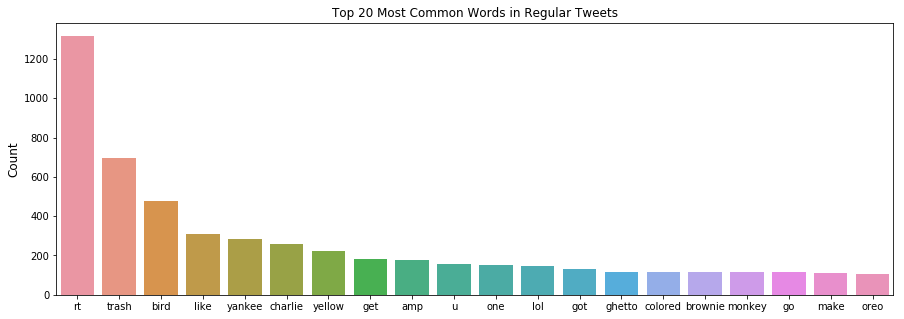

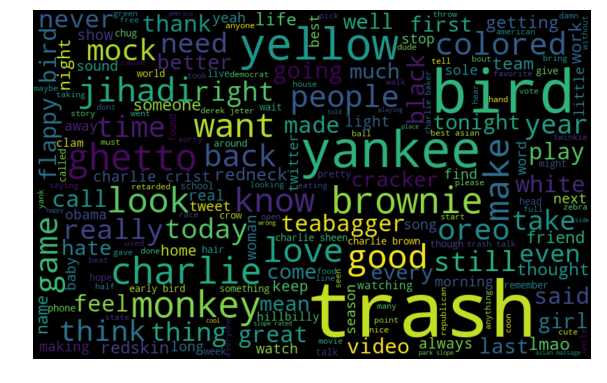

In [53]:
word_bar_plot(regular_tweets, 20, 'Regular')
word_cloud(regular_tweets)

<a id="offensive_count"></a>
### Offensive tweets

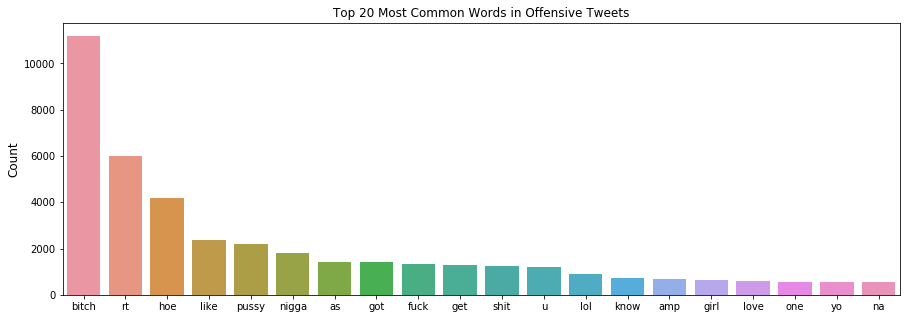

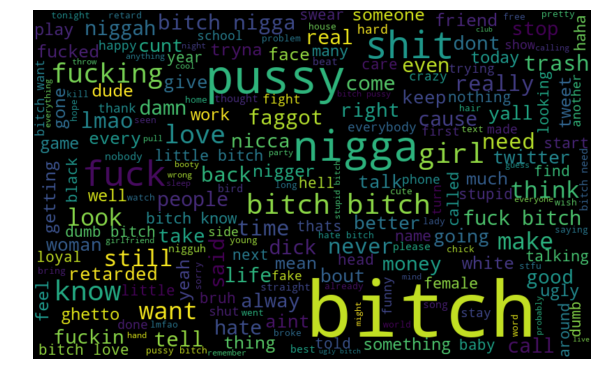

In [54]:
word_bar_plot(offensive_tweets, 20, 'Offensive')
word_cloud(offensive_tweets)

<a id="hate_count"></a>
### Hate tweets

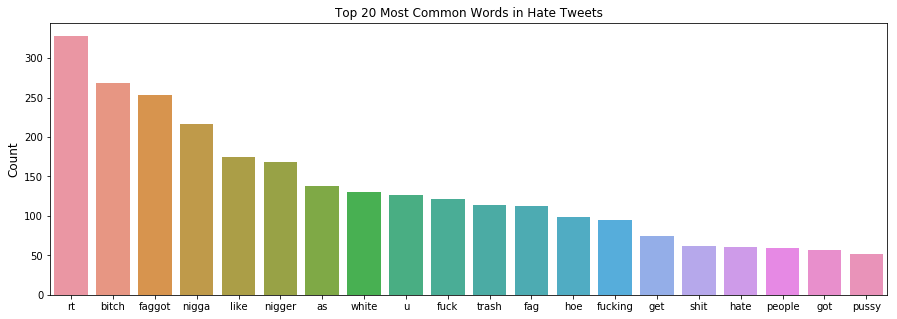

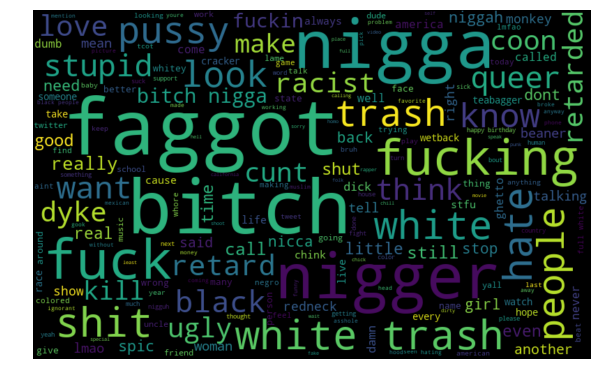

In [55]:
word_bar_plot(hate_tweets, 20, 'Hate')
word_cloud(hate_tweets)

In [22]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [44]:
werds = ['gife', 'gonk']
' '.join([w for w in werds])

'gife gonk'